
# Project 1 — Parts c)–f)
This notebook solves **c, d, e, f** using the provided modules in this repo:
`data.py`, `grad.py`, `metrics.py`, `models.py`, `plots.py`, `resampling.py`, `utils.py`.


In [7]:

import sys, pathlib

# project root (parent of Notebooks/) so `from Code...` works
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale
from Code.metrics import mse, r2
from Code.models import predict_from_theta
from Code.grad import gd, grad_ridge, grad_ols

## Data & Features (from `data.py`)

In [4]:

import numpy as np
import matplotlib.pyplot as plt

# Generate data and polynomial features
x, y = make_data()
degree = 15
X_full = build_features(x, degree=degree, include_bias=False)

# Split + scale (fit scaler only on train) and center y
X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=0.3, random_state=1, center_y=True)

# We'll consistently use centered y for training and add back y_mean on predictions.
print("Shapes:", X_tr_s.shape, X_te_s.shape)


Shapes: (210, 15) (90, 15)



## c) Gradient Descent for OLS and Ridge (using `grad.py`)

We first use the plain gradient descent method.


In [21]:
# Standardized design matrix, p is number of features
p = X_tr_s.shape[1]  

# OLS via gradient descent
theta_ols = gd(X_tr_s, y_tr_c, eta=0.1, iters=30, theta0=np.zeros(p), lam=None) # lam=None → OLS
yhat_te_ols = predict_from_theta(X_te_s, theta_ols, y_mean) # add back y_mean
mse_ols = mse(y_te, yhat_te_ols) 
r2_ols  = r2(y_te, yhat_te_ols) 

# Ridge via gradient descent (λ given)
lam = 1e-3
theta_ridge = gd(X_tr_s, y_tr_c, eta=5e-3, iters=6000, theta0=np.zeros(p), lam=lam) # lam=float → Ridge
yhat_te_ridge = predict_from_theta(X_te_s, theta_ridge, y_mean) # add back y_mean
mse_ridge = mse(y_te, yhat_te_ridge) 
r2_ridge  = r2(y_te, yhat_te_ridge)

print(f"OLS  — Test MSE: {mse_ols:.5f}, R²: {r2_ols:.4f}")
print(f"Ridge (λ={lam}) — Test MSE: {mse_ridge:.5f}, R²: {r2_ridge:.4f}")


OLS  — Test MSE: 0.15105, R²: 0.2277
Ridge (λ=0.001) — Test MSE: 0.13985, R²: 0.2850



## d) Optimizers: Momentum, AdaGrad, RMSProp, Adam

We keep the same objectives but change the update rule. We'll reuse `grad.grad_ridge` for the gradient and implement the optimizers here.


In [22]:
""" Compare different optimizers.
Beta: momentum parameter (for momentum, Adam)
eps: small number to avoid division by zero (for Adagrad, RMSprop, Adam)
rho: decay rate for moving average of squared gradients (for RMSprop)
b1, b2: decay rates for moving averages of gradient and squared gradient (for Adam
 """
def run_optimizer(X, y, lam, eta, iters, optimizer="sgd",  
                  beta=0.3, eps=1e-8, rho=0.99, b1=0.9, b2=0.999, seed=42): # optimizer hyperparameters
    n, p = X.shape # n samples, p features
    rng = np.random.default_rng(seed) # for reproducibility
    theta = np.zeros(p, float) # initial parameters
    v = np.zeros_like(theta) # velocity for momentum
    s = np.zeros_like(theta) # squared gradient accumulator for Adagrad, RMSprop, Adam
    m = np.zeros_like(theta) # first moment estimate for Adam
    t = 0 # timestep for Adam

    for k in range(iters): # main loop
        g = grad_ridge(X, y, theta, lam) if lam is not None else grad_ols(X, y, theta) # gradient
        t += 1 # increment timestep
         # Update parameters according to chosen optimizer
        if optimizer == "sgd": # Stochastic Gradient Descent
            theta -= eta * g # SGD update
        elif optimizer == "momentum": # Momentum
            v = beta * v + (1 - beta) * g # update velocity
            theta -= eta * v # update parameters
        elif optimizer == "adagrad": # Adagrad
            s += g * g # accumulate squared gradients
            theta -= (eta / (np.sqrt(s) + eps)) * g # update parameters
        elif optimizer == "rmsprop": # RMSprop
            s = rho * s + (1 - rho) * (g * g) # decaying average of squared gradients
            theta -= (eta / (np.sqrt(s) + eps)) * g # update parameters
        elif optimizer == "adam": # Adam
            m = b1 * m + (1 - b1) * g # update biased first moment estimate
            s = b2 * s + (1 - b2) * (g * g) # update biased second moment estimate
            m_hat = m / (1 - b1**t) # bias-corrected first moment
            s_hat = s / (1 - b2**t) # bias-corrected second moment
            theta -= eta * m_hat / (np.sqrt(s_hat) + eps)  # update parameters
        else:
            raise ValueError("Unknown optimizer") # unknown optimizer
    return theta 

opts = ["sgd","momentum","adagrad","rmsprop","adam"] # list of optimizers
results = {} # dictionary to store results
lam_d = 1e-3 # regularization strength
for opt in opts: 
    th = run_optimizer(X_tr_s, y_tr_c, lam=lam_d, eta=5e-3, iters=5000, optimizer=opt) # run optimizer
    yhat = predict_from_theta(X_te_s, th, y_mean) # make predictions
    results[opt] = (mse(y_te, yhat), r2(y_te, yhat)) # store results

# Compare results
for k,(mse_v,r2_v) in results.items(): 
    print(f"{k:8s}  MSE={mse_v:.5f}  R²={r2_v:.4f}") 


sgd       MSE=0.14090  R²=0.2796
momentum  MSE=0.14090  R²=0.2796
adagrad   MSE=0.14173  R²=0.2754
rmsprop   MSE=0.12626  R²=0.3545
adam      MSE=0.12563  R²=0.3577


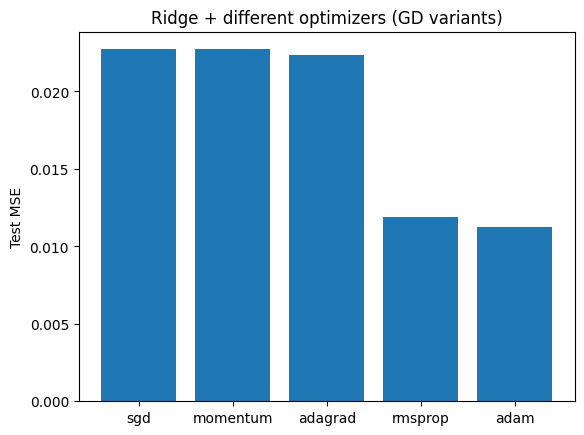

In [5]:

# Simple bar plot of test MSE across optimizers
vals = [results[k][0] for k in opts]
import matplotlib.pyplot as plt
plt.figure()
plt.bar(opts, vals)
plt.ylabel("Test MSE")
plt.title("Ridge + different optimizers (GD variants)");



## e) LASSO via Proximal Gradient (ISTA)

LASSO isn't implemented in the provided modules, so we implement the solver here and evaluate with `metrics.py`.


In [ ]:
# LASSO via ISTA (Iterative Soft-Thresholding Algorithm)
def soft_threshold(u, tau):
    return np.sign(u) * np.maximum(np.abs(u) - tau, 0.0) # soft-thresholding operator

# ISTA for LASSO regression
def ista_lasso(X, y, lam=1e-3, iters=6000, eta=None, seed=0): 
    n, p = X.shape
    if eta is None: 
        # conservative step via power iteration for spectral norm of X
        v = np.random.default_rng(seed).normal(size=p) 
        for _ in range(20): 
            v = X.T @ (X @ v) 
            v /= (np.linalg.norm(v) + 1e-12)
        L = (2.0 / n) * (np.linalg.norm(X @ v)**2) # Lipschitz constant
        eta = 1.0 / (L + 1e-12) # step size
    theta = np.zeros(p) 
    # ISTA main loop
    for _ in range(iters):
        g = (X.T @ (X @ theta - y)) * (2.0 / n) # gradient of least squares loss
        theta = soft_threshold(theta - eta * g, eta * lam) # LASSO update
    return theta 

lam_l1 = 1e-3
theta_lasso = ista_lasso(X_tr_s, y_tr_c, lam=lam_l1, iters=30) 
yhat_lasso = predict_from_theta(X_te_s, theta_lasso, y_mean) # add back y_mean
mse_lasso = mse(y_te, yhat_lasso) 
r2_lasso  = r2(y_te, yhat_lasso)
print(f"LASSO (ISTA, λ={lam_l1}) — Test MSE: {mse_lasso:.5f}, R²: {r2_lasso:.4f}")


LASSO (ISTA, λ=0.001) — Test MSE: 0.14934, R²: 0.2364


In [25]:
# OPTION 2 NON ISTA

def lasso_gd(X, y, theta, eta, lmbda, Niterations):
    """
    LASSO via plain (sub)gradient descent with fixed learning rate.
    Matches the style of your OLS+L1 example: OLS_gradient_component + L1_gradient_component.
    """
    n = X.shape[0]  # number of samples
    for iter in range(Niterations):
        # 1) OLS gradient component: (2/n) * X^T (X theta - y)
        residual = X @ theta - y
        OLS_gradient_component = (2.0 / n) * (X.T @ residual)

        # 2) L1 gradient component (subgradient): lambda * sign(theta)
        # (note: at theta_i = 0 the subgradient is any value in [-1, 1]; using sign(0)=0 is a common practical choice)
        L1_gradient_component = lmbda * np.sign(theta)

        # 3) Total gradient
        total_gradient = OLS_gradient_component + L1_gradient_component

        # 4) Parameter update with fixed learning rate
        theta -= eta * total_gradient

    return theta


p = X_tr_s.shape[1]
theta0 = np.zeros(p)

eta       = 5e-3     # learning rate (tune as needed)
lmbda     = 1e-3     # L1 penalty strength
Niterations = 30   # number of iterations

theta_lasso = lasso_gd(X_tr_s, y_tr_c, theta=theta0, eta=eta, lmbda=lmbda, Niterations=Niterations)

# Evaluate (your helpers)
yhat_lasso = predict_from_theta(X_te_s, theta_lasso, y_mean)
mse_lasso  = mse(y_te, yhat_lasso)
r2_lasso   = r2(y_te, yhat_lasso)

print(f"LASSO (GD, λ={lmbda}) — Test MSE: {mse_lasso:.5f}, R²: {r2_lasso:.4f}")


LASSO (GD, λ=0.001) — Test MSE: 0.17217, R²: 0.1197



## f) Stochastic Gradient Descent (mini-batch) variants

Mini-batch versions of the optimizers for Ridge. We reuse `grad.grad_ridge`.


MSE (full-batch Adam): 0.011268330177090573   MSE (mini-batch Adam): 0.020195959659633535


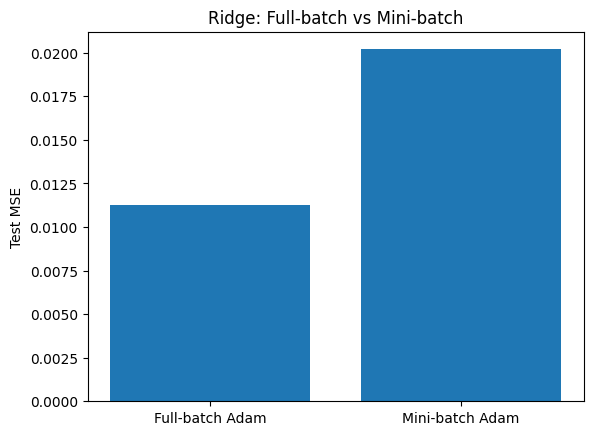

In [8]:

def sgd_minibatch(X, y, lam=1e-3, epochs=40, batch_size=64, eta=1e-2, optimizer="adam",
                  beta=0.9, eps=1e-8, rho=0.99, b1=0.9, b2=0.999, seed=0):
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p, float)
    v = np.zeros_like(theta)
    s = np.zeros_like(theta)
    m = np.zeros_like(theta)
    t = 0
    for ep in range(epochs):
        idx = rng.permutation(n)
        for start in range(0, n, batch_size):
            b = idx[start:start+batch_size]
            Xb, yb = X[b], y[b]
            # gradient on batch
            nb = Xb.shape[0]
            r = Xb @ theta - yb
            g = (Xb.T @ r) * (2.0 / nb) + lam * 2.0 * theta
            t += 1
            if optimizer == "sgd":
                theta -= eta * g
            elif optimizer == "momentum":
                v = beta * v + (1 - beta) * g
                theta -= eta * v
            elif optimizer == "adagrad":
                s += g * g
                theta -= (eta / (np.sqrt(s) + eps)) * g
            elif optimizer == "rmsprop":
                s = rho * s + (1 - rho) * (g * g)
                theta -= (eta / (np.sqrt(s) + eps)) * g
            elif optimizer == "adam":
                m = b1 * m + (1 - b1) * g
                s = b2 * s + (1 - b2) * (g * g)
                m_hat = m / (1 - b1**t)
                s_hat = s / (1 - b2**t)
                theta -= eta * m_hat / (np.sqrt(s_hat) + eps)
            else:
                raise ValueError("Unknown optimizer")
    return theta

theta_full = run_optimizer(X_tr_s, y_tr_c, lam=1e-3, eta=5e-3, iters=4000, optimizer="adam")
theta_sgd  = sgd_minibatch(X_tr_s, y_tr_c, lam=1e-3, epochs=25, batch_size=64, eta=1e-2, optimizer="adam")

yhat_full = predict_from_theta(X_te_s, theta_full, y_mean)
yhat_sgd  = predict_from_theta(X_te_s, theta_sgd,  y_mean)

mse_full = mse(y_te, yhat_full)
mse_sgd  = mse(y_te, yhat_sgd)

import matplotlib.pyplot as plt
plt.figure()
plt.bar(["Full-batch Adam", "Mini-batch Adam"], [mse_full, mse_sgd])
plt.ylabel("Test MSE"); plt.title("Ridge: Full-batch vs Mini-batch");
print("MSE (full-batch Adam):", mse_full, "  MSE (mini-batch Adam):", mse_sgd)



### Notes
- `data.py` handles **feature construction**, **train/test split**, **scaling**, and **centering**.  
- `grad.py` supplies the **OLS/Ridge gradients** and a **plain GD loop** used in part (c).  
- `metrics.py` provides **MSE** and **R²** used across parts (c)–(f).  
- `models.py` is kept for reference (closed-form fits) but the GD/SGD experiments here intentionally use gradients.  
- `plots.py` has helpers for specific sweeps; we did ad‑hoc plots tailored to GD/SGD results.
